In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, \
                              get_system_from_template, \
                              get_arch_from_template, \
                              get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA

import os
os.chdir('../../')

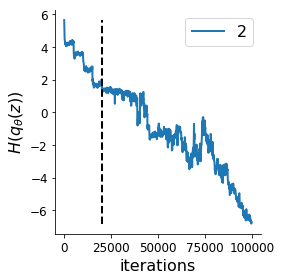

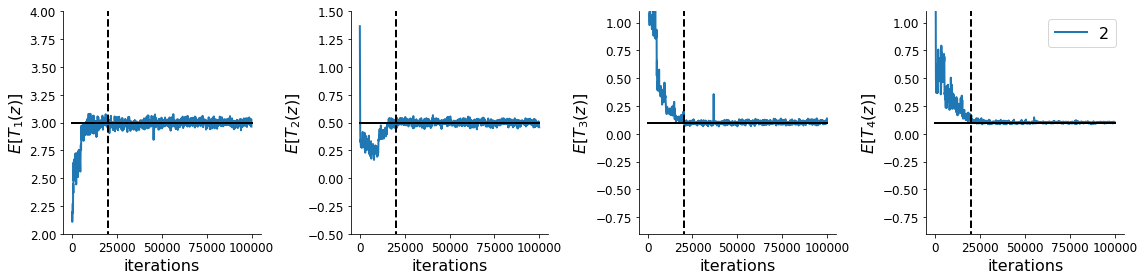

[array(4)]


In [2]:
variance = 0.1
c_init_order = 0
start_rs = 2
num_rs = 1

repeats = 1
sigma_init = 2.0
nlayers = 2
upl = 10

sysname = 'LowRankRNN'
dirstr = 'LowRankRNN'
rank = 1
input_type = 'input'
behavior_type = 'BI'
param_dict = {'rank':rank,
              'input_type':input_type,
              'behavior_type':behavior_type,
              'solve_its':50,
              'variance':variance,
              'gauss_newton':False,
              'solve_eps':0.2}
system = get_system_from_template(sysname, param_dict)

alpha=0.05
frac_samps=0.2
tol = []
tol_inds = []

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol_inds':[],
}

best_models = []
ME_its = []

arch_params = {
               'D':system.D,
               'sigma_init':sigma_init,
               'repeats':repeats,
               'nlayers':nlayers,
               'upl':upl,
              }

param_dict.update(arch_params)
arch_dict = get_arch_from_template(system, param_dict)

model_dirs = []
for rs in range(start_rs, start_rs+num_rs):
    model_dirs.append(get_savedir(system, arch_dict, c_init_order, rs, dirstr))
legendstrs = np.arange(start_rs, start_rs+num_rs)
figs, ME_its = plot_opt(model_dirs, legendstrs=legendstrs, con_method='mix',
                        alpha=alpha, frac_samps=frac_samps, \
                        tol=tol, tol_inds=tol_inds, maxconlim=1)
print(ME_its)


0
dist (300, 3)


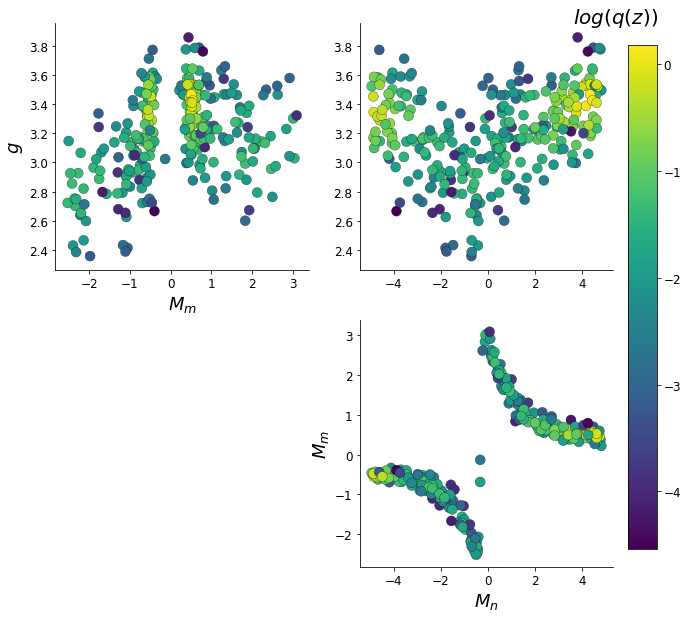

In [3]:
Zs, log_q_zs, axs = dsn_pairplots(model_dirs, 'Zs', system, AL_final_its=ME_its, fontsize=18,
                                  c_str='log_q_z', outlier_stds=2)

0
dist (300, 3)


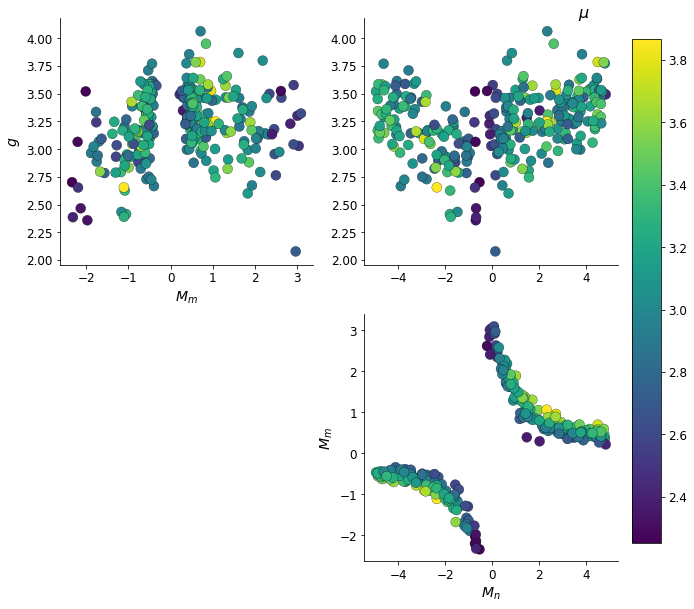

In [30]:
Zs, gammas, axs = dsn_pairplots(model_dirs, 'Zs', system, AL_final_its=ME_its, c_str='T_x1', outlier_stds=2)

0
dist (300, 3)


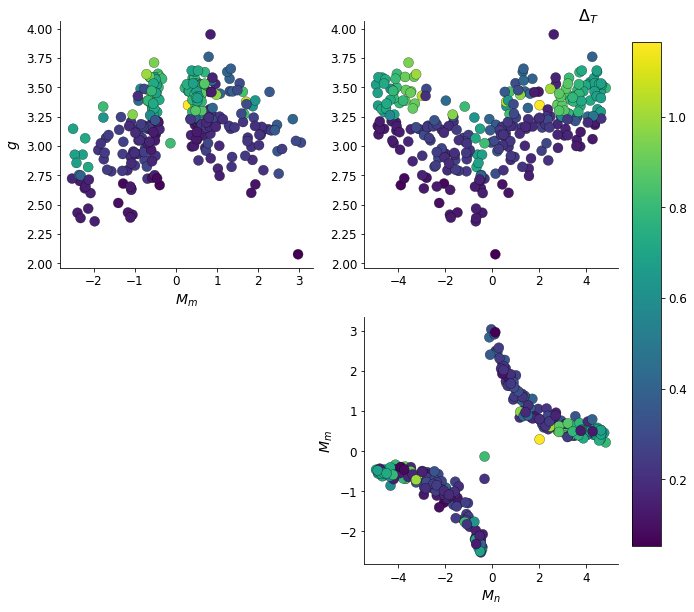

In [29]:
Zs, gammas, axs = dsn_pairplots(model_dirs, 'Zs', system, AL_final_its=ME_its, c_str='T_x2', outlier_stds=2)

0
dist (300, 4)


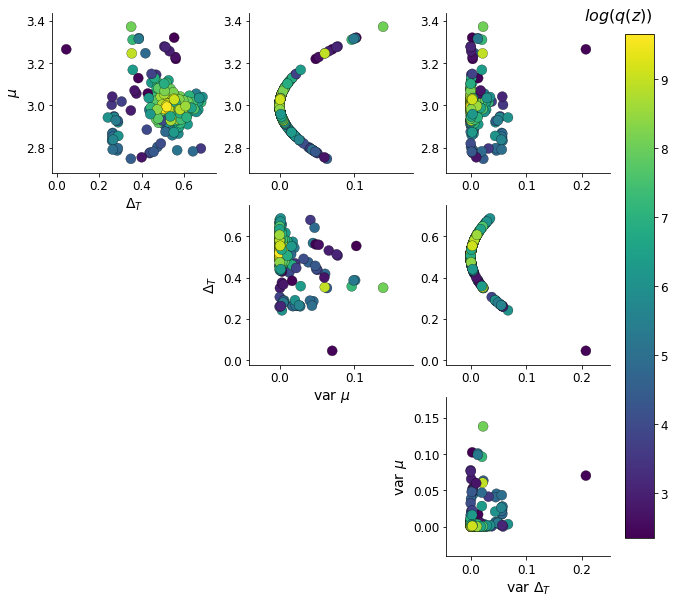

In [13]:

_, _, axs = dsn_pairplots(model_dirs, 'T_xs', system, ME_its)


In [24]:
from dsn.util.np_lrrnn import sample_LRRNN, sim_RNN, measure_mu, measure_kappa, measure_vars

Z = Zs[0]
M = Z.shape[0]
M = 20
N = 1000
n_samps = 10
t_start = 400
T = 800

mus = np.zeros((M, n_samps))
kappas = np.zeros((M, n_samps))
delta_infs = np.zeros((M, n_samps))
delta_Ts = np.zeros((M, n_samps))

np.random.seed(0)
for i in range(M):
    print('i', i)
    Z_i = Z[i,:]
    g = Z_i[0]
    Mm = Z_i[1]
    Mn = Z_i[2]
    for j in range(n_samps):
        params = {'nettype':'rank1_input', 'g':g, 'Mm':Mm, 'Mn':Mn, 
                  'MI':2.0, 'Sm':1.0, 'Sn':1.0, 'SI':0.0,
                  'SnI':1.0, 'SmI':0.0, 'Sperp':0.0}
        LRRNN = sample_LRRNN(N, params)
        W = LRRNN['W']
        m = LRRNN['m']
        n = LRRNN['n']
        I = LRRNN['I']
        x0 = m[:,0]

        dt = 0.005
        tau = 0.005
        T = 800
        x = sim_RNN(x0, W, I[:,0], dt, tau, T)
        kappa = measure_kappa(x, n[:,0], t_start)
        mu = measure_mu(kappa, m[:,0], I[:,0], t_start)
        delta_inf, delta_T = measure_vars(x, t_start)
        
        mus[i,j] = mu
        kappas[i,j] = kappa
        delta_infs[i,j] = delta_inf
        delta_Ts[i,j] = delta_T

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15
i 16
i 17
i 18
i 19


In [25]:
mu_means = np.mean(mus, axis=1)
mu_vars = np.var(mus, axis=1)
mu_stderr = np.sqrt(mus) / np.sqrt(n_samps)

kappa_means = np.mean(kappas, axis=1)
kappa_vars = np.var(kappas, axis=1)
kappa_stderr = np.sqrt(kappa_vars) / np.sqrt(n_samps)

delta_inf_means = np.mean(delta_infs, axis=1)
delta_inf_vars = np.var(delta_infs, axis=1)
delta_inf_stderr = np.sqrt(delta_inf_vars) / np.sqrt(n_samps)

delta_T_means = np.mean(delta_Ts, axis=1)
delta_T_vars = np.var(delta_Ts, axis=1)
delta_T_stderr = np.sqrt(delta_T_vars) / np.sqrt(n_samps)

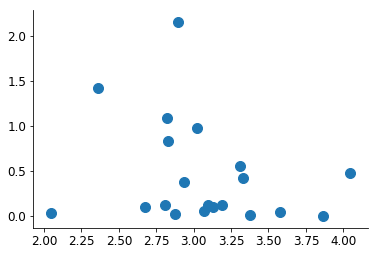

In [26]:
plt.figure()
plt.scatter(mu_means, delta_T_means)
plt.show()